# Descripción del problema

Crear un algoritmo de clasificación que ayude a predecir si un cliente del Banco Portugués suscribirá o no un depósito a plazo.

### Primero se instalan e importan las librerías
ejecutar en consola: `pip install -r requirements.txt`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Step 1: cargar archivo

In [2]:
# se carga archivo de la web
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv', delimiter=';')

In [3]:
df_raw.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
23727,30,admin.,married,university.degree,no,yes,no,cellular,aug,thu,...,23,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
33461,33,self-employed,married,basic.9y,no,unknown,unknown,cellular,may,tue,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no
40472,35,admin.,married,university.degree,no,yes,no,cellular,aug,wed,...,2,6,3,success,-1.7,94.027,-38.3,0.903,4991.6,yes


In [4]:
# se guarda en la carpeta data/raw
df_raw.to_csv('../data/raw/dataset_bank.csv')

### Diccionario de variables

* Age (numerical)
* Job: Type of Job (categorical)
* Marital: marital status (categorical)
* Education: (categorical)
* Default: has credit in default? (categorical)
* Housing: has housing loan? (categorical)
* Loan: has personal loan? (categorical)
* contact: contact communication type (categorcial)
* month: last contact month of year (categorical)
* day_of_week: last contact day of the week (categorical)
* duration: last contact duration, in seconds (numerical)
**Important note:** this output highly affects the output target (if duration = 0, then y = 'no'). Yet, the duration is not known before a call is performed. Also, after the end of the call, y is obviously known. Consider if you should include it or not for a realistic predictive model.
* campaign: number of contacts performed during this campaign and for this client (numerical)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numerical)
* poutcome: outcome of the previous marketing campaign (categorical)
**Important note:** this attribute has three categories: 'failure', 'success' and 'non-existent'. 86% of the data falls into 'non-existent' category.
* emp.var.rate: employment variation rate - quarterly indicator (numeric)
* cons.price.idx: consumer price index- monthly indicator (numeric)
* cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* euribor3m: euribor 3 month rate: - daily indicator(numeric)
* nr.employed: number of employees - quarterly indicator (numeric)
* **Target variable:** y, has the client subscribed a term deposit?

### Steps 2 y 3: Breve EDA del dataset

In [33]:
# se carga desde la carpeta
df_bank = pd.read_csv('../data/raw/dataset_bank.csv', index_col = 0)

In [6]:
# chequeo dimensiones
df_bank.shape

(41188, 21)

El data frame contiene 41188 registros (filas) y 21 variables (columnas)

In [7]:
# miro 5 observaciones al azar
df_bank.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
13140,51,blue-collar,married,basic.4y,unknown,yes,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
4145,47,admin.,married,university.degree,no,no,no,telephone,may,mon,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
39113,34,admin.,married,university.degree,no,yes,no,cellular,dec,tue,...,2,999,0,nonexistent,-3.0,92.713,-33.0,0.707,5023.5,no
27820,33,admin.,married,university.degree,no,yes,no,cellular,mar,thu,...,3,999,0,nonexistent,-1.8,92.843,-50.0,1.650,5099.1,no
20190,41,self-employed,married,university.degree,no,no,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no


In [8]:
# info básica
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Apreciaciones:**

* no hay valores nulos en ninguna de las variables
* hay que convertir las variables de tipo object a categorical

#### Visualización de las categorías de cada variable categórica y cómo se distribuyen, recodificación para sustituir categorías "unknown"

Tipo de trabajo

In [34]:
# Tipo de trabajo
print(df_bank['job'].value_counts())
print(f'Cantidad de categorías: {df_bank["job"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['job'] == 'unknown'
df_bank.loc[mask, 'job'] = 'admin.'
print(df_bank['job'].value_counts())

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
Cantidad de categorías: 12
admin.           10752
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64


Estado civil

In [35]:
# Estado civil
print(df_bank['marital'].value_counts())
print(f'Cantidad de categorías: {df_bank["marital"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['marital'] == 'unknown'
df_bank.loc[mask, 'marital'] = 'married'
print(df_bank['marital'].value_counts())

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
Cantidad de categorías: 4
married     25008
single      11568
divorced     4612
Name: marital, dtype: int64


Nivel educativo

In [36]:
# Nivel educativo
print(df_bank['education'].value_counts())
print(f'Cantidad de categorías: {df_bank["education"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['education'] == 'unknown'
df_bank.loc[mask, 'education'] = 'university.degree'
print(df_bank['education'].value_counts())

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
Cantidad de categorías: 8
university.degree      13899
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: education, dtype: int64


Créditos en default?

In [37]:
# Tiene créditos en default?
print(df_bank['default'].value_counts())
print(f'Cantidad de categorías: {df_bank["default"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['default'] == 'unknown'
df_bank.loc[mask, 'default'] = 'no'
print(df_bank['default'].value_counts())

no         32588
unknown     8597
yes            3
Name: default, dtype: int64
Cantidad de categorías: 3
no     41185
yes        3
Name: default, dtype: int64


Préstamo de vivienda?

In [38]:
# Tiene préstamo de vivienda?
print(df_bank['housing'].value_counts())
print(f'Cantidad de categorías: {df_bank["housing"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['housing'] == 'unknown'
df_bank.loc[mask, 'housing'] = 'yes'
print(df_bank['housing'].value_counts())


yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
Cantidad de categorías: 3
yes    22566
no     18622
Name: housing, dtype: int64


Algún préstamo?

In [39]:
# Tiene algún préstamo?
print(df_bank['loan'].value_counts())
print(f'Cantidad de categorías: {df_bank["loan"].nunique()}')

# sustituyo categoría "unknown" por la más frecuente
mask = df_bank['loan'] == 'unknown'
df_bank.loc[mask, 'loan'] = 'no'
print(df_bank['loan'].value_counts())


no         33950
yes         6248
unknown      990
Name: loan, dtype: int64
Cantidad de categorías: 3
no     34940
yes     6248
Name: loan, dtype: int64


Tipo de contacto

In [40]:
# Tipo de contacto
print(df_bank['contact'].value_counts())
print(f'Cantidad de categorías: {df_bank["contact"].nunique()}')

# esta variable no tiene categoría "unknown" 

cellular     26144
telephone    15044
Name: contact, dtype: int64
Cantidad de categorías: 2


Mes del último contacto

In [41]:
# Mes del último contacto
print(df_bank['month'].value_counts())
print(f'Cantidad de categorías: {df_bank["month"].nunique()}')

# esta variable no tiene categoría "unknown" 

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64
Cantidad de categorías: 10


Día de la semana del último contacto

In [42]:
# Día de la semana del último contacto
print(df_bank['day_of_week'].value_counts())
print(f'Cantidad de categorías: {df_bank["day_of_week"].nunique()}')

# esta variable no tiene categoría "unknown" 

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64
Cantidad de categorías: 5


Resultado de la campaña anterior

In [43]:
# Resultado de la campaña anterior
print(df_bank['poutcome'].value_counts())
print(f'Cantidad de categorías: {df_bank["poutcome"].nunique()}')

# esta variable no tiene categoría "unknown" 

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64
Cantidad de categorías: 3


Se convierten a categorical

In [44]:
# convierto a categóricas
cols = df_bank.select_dtypes(include = ['object']).columns
for i in cols:
    df_bank[i] = pd.Categorical(df_bank[i])
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

Ahora se analiza la variable target

In [20]:
# variable respuesta, dependiente o target: cliente suscribió un plazo fijo?
print(df_bank['y'].value_counts())
print(f'Cantidad de categorías: {df_bank["y"].nunique()}')

no     36548
yes     4640
Name: y, dtype: int64
Cantidad de categorías: 2


In [21]:
print(f'yes = {round(100*sum(df_bank["y"] == "yes")/len(df_bank))}%')
print(f'no = {round(100*sum(df_bank["y"] == "no")/len(df_bank))}%')

yes = 11%
no = 89%


La distribución de la variable target está desbalanceada!!

Resumen de las variables numéricas:

In [22]:
df_bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Cosas que llaman la atención:
* hay contactos con duración = 0 (no hubo contacto anterior, además según indica el diccionario esos tienen y = 'No')
* en pdays hay que tener cuidado con 999 (si es la primera campaña)



In [31]:
mask = df_bank['pdays']<999
df_bank.loc[mask, 'pdays'].describe()

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: pdays, dtype: float64

Solamente hay 1515 valores de pdays distintos de 999 en 41188 observaciones

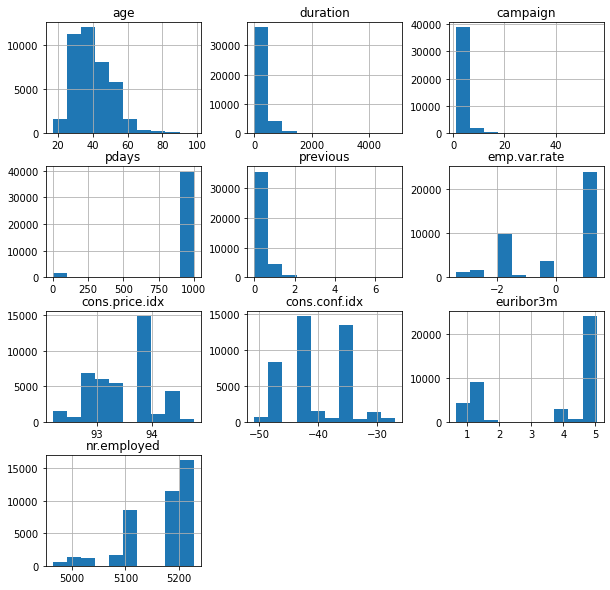

In [23]:
# histogramas
df_bank.hist(figsize=(10, 10))
plt.show()

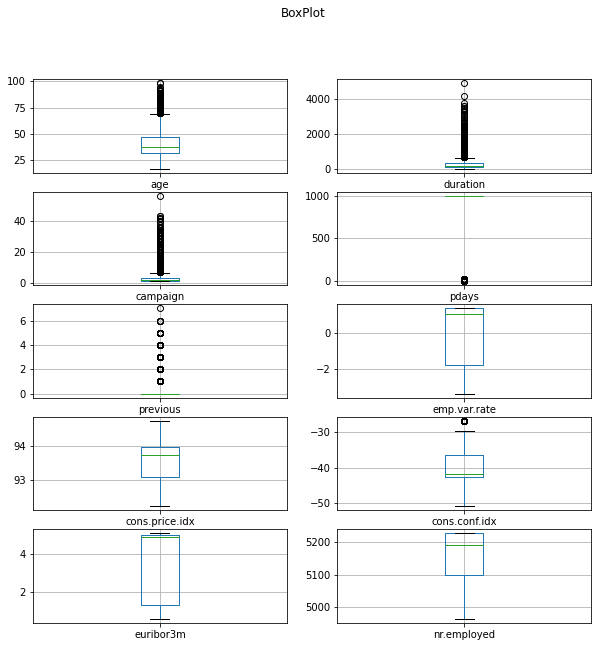

In [23]:
# boxplot
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
axs = ax.flatten()
for i in range(len(axs)):
    df_bank._get_numeric_data().iloc[:, i].to_frame().boxplot(ax=axs[i])
plt.suptitle("BoxPlot")
plt.show()

La distribución de duration está concentrada en valores pequeños, lo mismo sucede con campaign, pdays y previous


In [24]:
# matriz de correlación
df_bank.corr().style.background_gradient(cmap='Blues')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


Las altas correlaciones se dan entre emp.var.rate (tasa de variación del empleo) y cons.price.idx (índice de precio al consumo): 0.77 , emp.var.rate y euribor3m (tasa de interés trimestral interbancaria europea): 0.97, emp.var.rate y nr.employed (número de empleados): 0.90, euribor3m y nr.employed (0.94).

Decido sacar emp.var.rate, nr.employed y pdays

In [45]:
df_bank = df_bank.drop(columns= ['pdays', 'emp.var.rate', 'nr.employed'], axis = 1)

In [27]:
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,no
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,no


In [28]:
df_bank.describe(include='category')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10752,25008,13899,41185,22566,34940,26144,13769,8623,35563,36548


### Valores atípicos

In [72]:
# vuelvo a ver el describe
df_bank.describe()

,age,duration,campaign,previous,cons.price.idx,cons.conf.idx,euribor3m
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,0.172963,93.575664,-40.502600,3.621291
std,10.42125,259.279249,2.770014,0.494901,0.578840,4.628198,1.734447
min,17.00000,0.000000,1.000000,0.000000,92.201000,-50.800000,0.634000
25%,32.00000,102.000000,1.000000,0.000000,93.075000,-42.700000,1.344000
50%,38.00000,180.000000,2.000000,0.000000,93.749000,-41.800000,4.857000
75%,47.00000,319.000000,3.000000,0.000000,93.994000,-36.400000,4.961000
max,98.00000,4918.000000,56.000000,7.000000,94.767000,-26.900000,5.045000


In [71]:
# busco y corrijo valores atípicos en variables numéricas
num_vars = df_bank.select_dtypes(include = ['int', 'float']).columns
for i in range(len(num_vars)):
    aux = df_bank[num_vars[i]].describe()
    IQR = aux['75%']-aux['25%']
    upper = aux['75%'] + 1.5*IQR
    lower = aux['25%'] - 1.5*IQR
    print(f'The upper & lower bounds for suspected outliers in {num_vars[i]} are {round(upper, 1)} and {round(lower, 1)}')


The upper & lower bounds for suspected outliers in age are 69.5 and 9.5
The upper & lower bounds for suspected outliers in duration are 644.5 and -223.5
The upper & lower bounds for suspected outliers in campaign are 6.0 and -2.0
The upper & lower bounds for suspected outliers in previous are 0.0 and 0.0
The upper & lower bounds for suspected outliers in cons.price.idx are 95.4 and 91.7
The upper & lower bounds for suspected outliers in cons.conf.idx are -26.9 and -52.2
The upper & lower bounds for suspected outliers in euribor3m are 10.4 and -4.1


Si bien hay varias variables que podrían tener outliers, no parecen ser valores tan llamativos. Ninguno me llama la atención como si fuera un error de tipeo o algo imposible

In [81]:
# creo rangos de edad
df_bank['range_age'] = pd.cut(df_bank['age'], [10,20,30,40,50,60,70,80,90,100])
df_bank['range_age'].value_counts(sort=False)

(10, 20]       140
(20, 30]      7243
(30, 40]     16385
(40, 50]     10240
(50, 60]      6270
(60, 70]       488
(70, 80]       303
(80, 90]       109
(90, 100]       10
Name: range_age, dtype: int64

In [ ]:
## Esto no lo entiendo: Insert categories 'basic.9y','basic.6y','basic4y' into 'middle_school'

In [82]:
# convierto target en binario
df_bank['y']=df_bank['y'].cat.codes
df_bank['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [83]:
# creo dummies para las variables categóricas
df_bank2 = pd.get_dummies(df_bank, columns=['job',	'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])
df_bank2.head()

,age,duration,campaign,previous,cons.price.idx,cons.conf.idx,euribor3m,y,range_age,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,0,93.994,-36.4,4.857,0,"(50, 60]",0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,0,93.994,-36.4,4.857,0,"(50, 60]",0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,0,93.994,-36.4,4.857,0,"(30, 40]",0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,0,93.994,-36.4,4.857,0,"(30, 40]",1,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,0,93.994,-36.4,4.857,0,"(50, 60]",0,...,0,0,0,1,0,0,0,0,1,0


In [46]:
# separo en X e y
X = df_bank.drop(columns = ['y'])
y = df_bank['y']

In [10]:
y = df_raw['y']

In [ ]:
X.select_dtypes(include = ['int', 'float']).columns